# Recommender System Using PySpark

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 23.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=825855d080060d31b15021100757b2a1f835919ed57293384a7728285b43dbe1
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql import Row
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('Recommendations').getOrCreate()

# New Section

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
lines = spark.read.options(header=True).csv("/content/gdrive/MyDrive/brainstation/transaction.csv")
df = lines.drop('sales_channel_id').drop('price').drop('t_dat')

In [8]:
# get unique customer and article ids so you can map them to integers as per pyspark requirements for ALS model
unique_customers = df.select('customer_id').distinct()
unique_articles = df.select('article_id').distinct()

In [9]:
customer_id_map = []
for i, c in enumerate(unique_customers.collect()):
    customer_id_map.append(Row(c['customer_id'], i))

In [10]:
article_id_map = []
for i, c in enumerate(unique_articles.collect()):
    article_id_map.append(Row(c['article_id'], i))

In [11]:
customer_map = spark.createDataFrame(customer_id_map, ['customer_id', 'int_customer_id'])


In [12]:
article_map = spark.createDataFrame(article_id_map, ['article_id', 'int_article_id'])


In [13]:
map_df = df.join(customer_map, 'customer_id').join(article_map, on='article_id')


In [14]:
map_df.show()


+----------+--------------------+----+------+---------------+--------------+
|article_id|         customer_id| _c0|Bought|int_customer_id|int_article_id|
+----------+--------------------+----+------+---------------+--------------+
| 456163030|000346516dd355b40...|1953|     1|              0|         19919|
| 485176004|000346516dd355b40...|1954|     1|              0|         31519|
| 507909001|000346516dd355b40...|1955|     1|              0|          3119|
| 534210011|000346516dd355b40...|1956|     1|              0|         25435|
| 557248003|000346516dd355b40...|1957|     1|              0|         23957|
| 642437010|000346516dd355b40...|1958|     1|              0|          9962|
| 666084001|000346516dd355b40...|1959|     1|              0|         35507|
| 669708001|000346516dd355b40...|1960|     1|              0|          8614|
| 685823003|000346516dd355b40...|1961|     1|              0|          5954|
| 694966001|000346516dd355b40...|1962|     1|              0|         40528|

In [15]:
user_item = map_df.groupby(['int_customer_id', 'int_article_id']).count()

In [16]:
user_item.show(100)

+---------------+--------------+-----+
|int_customer_id|int_article_id|count|
+---------------+--------------+-----+
|             16|         15218|    1|
|             30|         22170|    1|
|             60|         29472|    1|
|             61|         26007|    1|
|             65|          2227|    1|
|             69|           580|    1|
|             70|          4699|    1|
|             75|         14052|    1|
|             75|           332|    1|
|             82|            10|    1|
|            100|         10726|    1|
|            100|          9172|    1|
|            117|         26900|    1|
|            118|         34585|    1|
|            127|         35897|    1|
|            151|         22947|    1|
|            152|         30936|    1|
|            164|         26382|    1|
|            193|          8081|    1|
|            199|         25455|    1|
|            204|         29348|    1|
|            214|         40532|    1|
|            227|        

In [17]:
#Train and Test split
(training, test) = user_item.randomSplit([0.7, 0.3])

# Model:

In [18]:
# Build the recommendation model using ALS on the training data

als = ALS(maxIter=5, regParam=0.15, userCol="int_customer_id", itemCol="int_article_id", ratingCol="count",
          coldStartStrategy="drop",implicitPrefs=True)
model = als.fit(training)

In [19]:
# Evaluate the model bythe RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9924982619437456


In [20]:
#  top k recommendations for a specified set of users
userRecs = model.recommendForAllUsers(10)

In [21]:
#  top k customer recommendations for a specified set of items
itemRecs = model.recommendForAllItems(10)

In [22]:
# Generate top 10 item recommendations for a specified set of users
users = user_item.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 10)

In [23]:
# Generate top 10 user recommendations for a specified set of items
items = user_item.select(als.getItemCol()).distinct().limit(3)
itemSubSetRecs = model.recommendForItemSubset(items, 10)

In [24]:
userRecs.show()
itemRecs.show()
userSubsetRecs.show()
itemSubSetRecs.show()

+---------------+--------------------+
|int_customer_id|     recommendations|
+---------------+--------------------+
|              1|[{35513, 0.003015...|
|             12|[{17781, 0.077041...|
|             13|[{3541, 0.0756314...|
|             22|[{23295, 0.045476...|
|             26|[{3541, 0.0027361...|
|             27|[{17781, 0.002199...|
|             28|[{23295, 0.136682...|
|             31|[{1565, 0.0738860...|
|             34|[{17781, 0.002558...|
|             44|[{38792, 0.024204...|
|             47|[{1565, 0.0568793...|
|             52|[{3541, 0.0038359...|
|             53|[{23295, 0.159417...|
|             65|[{1565, 0.0491139...|
|             76|[{38792, 0.065298...|
|             81|[{10885, 0.030669...|
|             85|[{1565, 0.1363146...|
|             91|[{1565, 0.0017414...|
|             93|[{42839, 0.033733...|
|            101|[{23295, 0.014637...|
+---------------+--------------------+
only showing top 20 rows

+--------------+--------------------+


In [25]:
userSubsetRecs.collect()[0][0]

474

In [28]:
def get_rcmnds(k=6):
    
    users = user_item.select(als.getUserCol()).distinct().limit(1)
    userSubsetRecs = model.recommendForUserSubset(users, k)
    
    items = user_item.select(als.getItemCol()).distinct().limit(1)
    itemSubSetRecs = model.recommendForItemSubset(items, k)

    cid = userSubsetRecs.collect()[0][0]
    aids = []
    for row in userSubsetRecs.collect()[0][1]:
        aids.append(row['int_article_id'])

    rcmnds = article_map.filter(article_map.int_article_id.isin(aids)).toPandas().article_id.values

    prev_items_int = user_item.filter(user_item.int_customer_id == cid).toPandas().int_article_id.values.tolist()

    prev_items = article_map.filter(article_map.int_article_id.isin(prev_items_int)).toPandas().article_id.values
    
    return users,rcmnds, prev_items

In [29]:
print(get_rcmnds(k=6))

(DataFrame[int_customer_id: bigint], array(['706016001', '706016002', '759871002', '706016003', '624486001',
       '759871001'], dtype=object), array(['825811006', '507909001', '827636001', '685823003', '816588001',
       '669708001', '642437010', '707777006', '854193002', '456163030',
       '557248003', '766955002', '534210011', '816423002', '809672001',
       '485176004', '666084001', '745232001', '699923041', '694966001'],
      dtype=object))


In [30]:
users, rcmnds, prev_items = get_rcmnds(k=6)

In [31]:
images_dir="/content/gdrive/MyDrive/capstone/images"

In [33]:
for iid, im_id in enumerate(prev_items):
  print(im_id)

825811006
507909001
827636001
685823003
816588001
669708001
642437010
707777006
854193002
456163030
557248003
766955002
534210011
816423002
809672001
485176004
666084001
745232001
699923041
694966001


In [34]:
for iid, im_id in enumerate(rcmnds):
  print(im_id)

706016001
706016002
759871002
706016003
624486001
759871001


# Look at the purchase history:

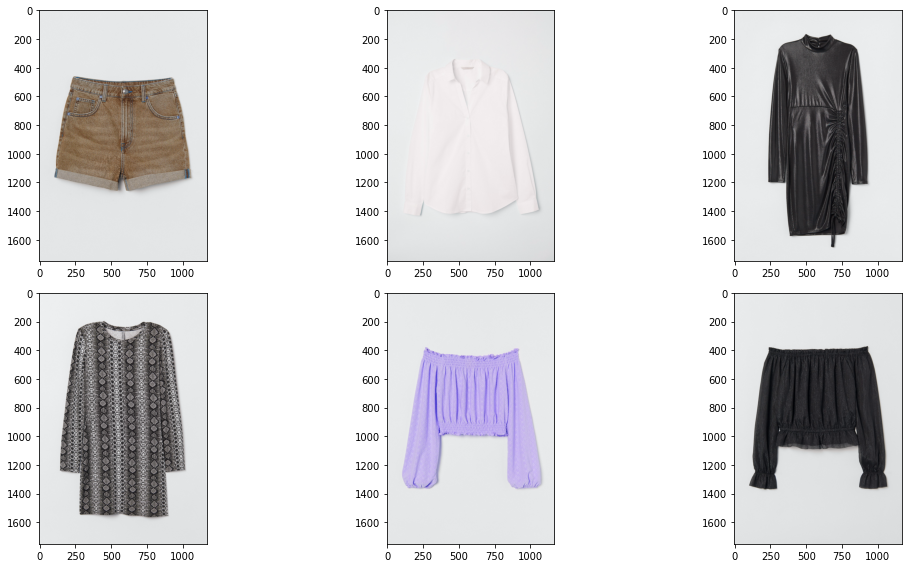

In [40]:

import cv2
#showing the images of recommendation for user index 3
figure, ax = plt.subplots(nrows=2,ncols=3,figsize=(16,8))
for iid, im_id in enumerate(prev_items):

    #that's how the image path is in my directory
        image_path = f'{images_dir}/0{im_id}.jpg'
        
        #using cv2 to read the image
        image=cv2.imread(image_path)
        
        try:
            #flatten it and then show it
            ax.ravel()[iid].imshow(image)
            
        except:
            continue;
            
#first plotting the layout of images            
plt.tight_layout()

#showing the whole set of images
plt.show()


# Look at the Recommendations:

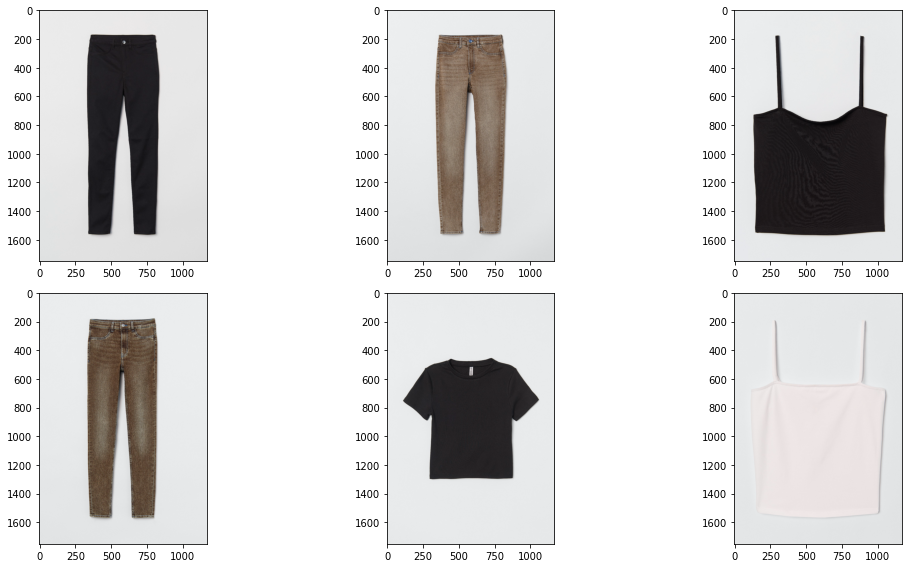

In [41]:
figure, ax = plt.subplots(nrows=2,ncols=3,figsize=(16,8))
for iid, im_id in enumerate(rcmnds):

    #that's how the image path is in my directory
        image_path = f'{images_dir}/0{im_id}.jpg'
        
        #using cv2 to read the image
        image=cv2.imread(image_path)
        
        try:
            #flatten it and then show it
            ax.ravel()[iid].imshow(image)
            
        except:
            continue;
            
#first plotting the layout of images            
plt.tight_layout()

#showing the whole set of images
plt.show()
